In [2]:
!pip install requests_oauthlib

In [7]:
import os
from skimage import io
from io import BytesIO
import cv2
import requests
import numpy as np
import pandas as pd
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import request
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'request'

In [4]:
df = pd.read_csv('minatoku.csv')

C:\Users\dev\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
df["地区"].unique()

array(['一の橋', '芝浦', '赤坂', '麻布', '港南'], dtype=object)

記事のコードの例

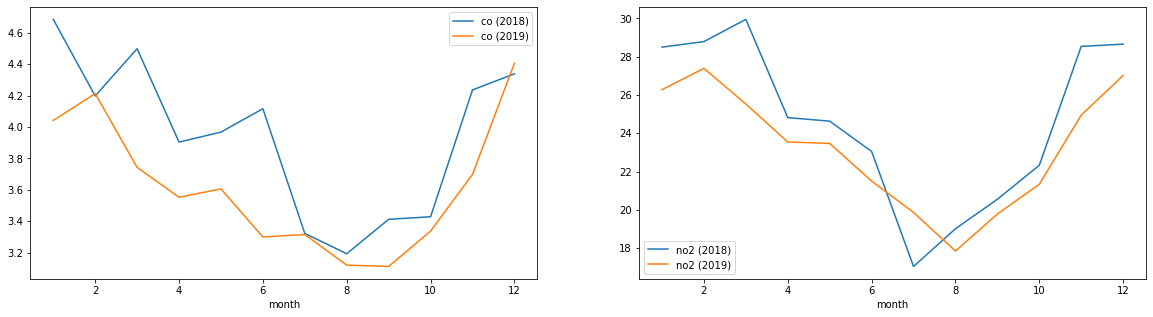

In [6]:
data = df.query('地区 == "一の橋"').set_index('ymd')
monthly = data.groupby(['year', 'month']).mean().rename(columns={'一酸化炭素[0.1ppm]': 'co', '二酸化硫黄[ppb]': 'so2', '二酸化窒素[ppb]': 'no2', 'オキシダント[ppb]': 'oxidant'})[['co', 'so2', 'no2', 'oxidant']]
plt.figure(figsize=(20, 5))
ax1 = plt.subplot(1, 2, 1)

monthly.loc[2018][['co']].rename(columns={'co': 'co (2018)'}).plot(ax=ax1)
monthly.loc[2019][['co']].rename(columns={'co': 'co (2019)'}).plot(ax=ax1)
ax2 = plt.subplot(1, 2, 2)
monthly.loc[2018][['no2']].rename(columns={'no2': 'no2 (2018)'}).plot(ax=ax2)
monthly.loc[2019][['no2']].rename(columns={'no2': 'no2 (2019)'}).plot(ax=ax2)

衛星データを取得する


In [9]:
bbox

[140.5755615, 35.169318, 139.0759277, 35.7821707]

Sentinal Hub

In [3]:
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

# Your client credentials
client_id = '5dc5d1a1-db6d-4431-bbf3-c582ec698a5d'
client_secret = 'g5&:D*PaTuJHTs:%]0%40Ee,MCg.N9[Shcj_~y)W'
# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)
# Get token for the session
token_info = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)
TOKEN = token_info['access_token']
# All requests using this session will have an access token automatically added
resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")

In [4]:
def get_s2_true_img(bbox,day):
    response = requests.post('https://services.sentinel-hub.com/api/v1/process',
    headers={"Authorization" : f"Bearer {TOKEN}"},
    json={
    "input": {
        "bounds": {
            "properties": {
                "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
            },
            "bbox": bbox
        },
        "data": [
            {
                "type": "S2L2A",
                "dataFilter": {
                    "timeRange": {
                         "from": f"{day}T00:00:00Z",
                          "to": f"{day}T23:59:59Z"
                    }
                }
            }
        ]
    },
    "output": {
        "width": 512,
        "height": 512
    },
    "evalscript": """
    //VERSION=3
    function setup() {
      return {
        input: ["B02", "B03", "B04"],
        output: { 
          bands: 3, 
          sampleType: "AUTO" // default value - scales the output values from [0,1] to [0,255].
        }
      }
    }
    function evaluatePixel(sample) {
      return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02]
    }

    """
    })
    img = Image.fromarray(io.imread(BytesIO(response.content)))
    img.putalpha(alpha=255)
    return np.array(img)

In [12]:
def get_co_img(bbox, day):
   
    json={
      "input": {
          "bounds": {
                  "properties": {
                  "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
              },
              "bbox": bbox
          },
          "data": [
              {
                  "type": "S5PL2",
                  "dataFilter": {
                      "timeRange": {
                          "from": f"{day}T00:00:00Z",
                          "to": f"{day}T23:59:59Z"
                      }
                  }
              }
          ]
      },
      "output": {
          "width": 512,
          "height": 512
      },
        
        
      
      "evalscript": """
      //VERSION=3

      function setup() {
        return {
          input: ["CO", "dataMask"],
          output: { bands:  4 }
        }
      }
      const minVal = 0.0
      const maxVal = 0.1
      const diff = maxVal - minVal
      const rainbowColors = [
          [minVal, [0, 0, 0.5]],
          [minVal + 0.125 * diff, [0, 0, 1]],
          [minVal + 0.375 * diff, [0, 1, 1]],
          [minVal + 0.625 * diff, [1, 1, 0]],
          [minVal + 0.875 * diff, [1, 0, 0]],
          [maxVal, [0.5, 0, 0]]
      ]
      const viz = new ColorRampVisualizer(rainbowColors)
      function evaluatePixel(sample) {
          var rgba= viz.process(sample.CO)
          rgba.push(sample.dataMask)
          return rgba
      }
      """
    }
    print(json)
    response = requests.post('https://creodias.sentinel-hub.com/api/v1/process',
    headers={"Authorization" : f"Bearer {TOKEN}"},json=json)
    
    return io.imread(BytesIO(response.content))

In [39]:

def get_co_img2(bbox, day,TOKEN):
   
    json={
      "input": {
          "bounds": {
                  "properties": {
                  "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
              },
              "bbox": bbox
          },
          "data": [
              {
                  "type": "S5PL2",
                  "dataFilter": {
                      "timeRange": {
                          "from": f"{day}T00:00:00Z",
                          "to": f"{day}T23:59:59Z"
                      }
                  }
              }
          ]
      },
      "output": {
          "width": 512,
          "height": 512
      },
      "evalscript": """
      //VERSION=3

      function setup() {
        return {
          input: ["CO", "dataMask"],
          output: { bands:  4 }
        }
      }
      const minVal = 0.0
      const maxVal = 0.1
      const diff = maxVal - minVal
      const rainbowColors = [
          [minVal, [0, 0, 0.5]],
          [minVal + 0.125 * diff, [0, 0, 1]],
          [minVal + 0.375 * diff, [0, 1, 1]],
          [minVal + 0.625 * diff, [1, 1, 0]],
          [minVal + 0.875 * diff, [1, 0, 0]],
          [maxVal, [0.5, 0, 0]]
      ]
      const viz = new ColorRampVisualizer(rainbowColors)
      function evaluatePixel(sample) {
          var rgba= viz.process(sample.CO)
          rgba.push(sample.dataMask)
          return rgba
      }
      """
    }
    response = requests.post('https://creodias.sentinel-hub.com/api/v1/process',
    headers={"Authorization" : f"Bearer {TOKEN}"},json=json)
    return io.imread(BytesIO(response.content))

In [5]:
def draw_texts(img, texts, font_scale=0.7, thickness=2):
    h, w, c = img.shape
    offset_x = 10  # 左下の座標
    initial_y = 450
    dy = int(img.shape[1] / 15)
    color = (255, 255, 255, 0)  # black

    texts = [texts] if type(texts) == str else texts

    for i, text in enumerate(texts):
        offset_y = initial_y + (i+1)*dy
        cv2.putText(img, text, (offset_x, offset_y), cv2.FONT_HERSHEY_SIMPLEX,
                    font_scale, color, thickness, cv2.LINE_AA)

def draw_result_on_img(img, texts, w_ratio=0.8, h_ratio=0.2, alpha=0.4):
    # 文字をのせるためのマットを作成する
    overlay = img.copy()
    pt1 = (0, 500)
    pt2 = (int(img.shape[1] * w_ratio), int(img.shape[0] * h_ratio))

    mat_color = (25, 25, 25)
    fill = -1  # -1にすると塗りつぶし
    cv2.rectangle(overlay, pt1, pt2, mat_color, fill)

    mat_img = cv2.addWeighted(overlay, alpha, img, 1 - alpha, 0)

    draw_texts(mat_img, texts)

    return mat_img

def add_copyright(img):
    new_img = draw_result_on_img(img, texts=["produced from ESA remote sensing data"], w_ratio=1.0, h_ratio=0.9, alpha=0.5)

    return new_img

In [36]:
imagetypes_eval={}

imagetypes_eval["TRUE_IMG"]="""
    //VERSION=3
    function setup() {
      return {
        input: ["B02", "B03", "B04"],
        output: { 
          bands: 3, 
          sampleType: "AUTO" // default value - scales the output values from [0,1] to [0,255].
        }
      }
    }
    function evaluatePixel(sample) {
      return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02]
    }
    """


imagetypes_eval["CO"]= """
      //VERSION=3

      function setup() {
        return {
          input: ["CO", "dataMask"],
          output: { bands:  4 }
        }
      }
      const minVal = 0.0
      const maxVal = 0.1
      const diff = maxVal - minVal
      const rainbowColors = [
          [minVal, [0, 0, 0.5]],
          [minVal + 0.125 * diff, [0, 0, 1]],
          [minVal + 0.375 * diff, [0, 1, 1]],
          [minVal + 0.625 * diff, [1, 1, 0]],
          [minVal + 0.875 * diff, [1, 0, 0]],
          [maxVal, [0.5, 0, 0]]
      ]
      const viz = new ColorRampVisualizer(rainbowColors)
      function evaluatePixel(sample) {
          var rgba= viz.process(sample.CO)
          rgba.push(sample.dataMask)
          return rgba
      }
      """


imagetypes_eval["SO"]= """
    //VERSION=3
    function setup() {
      return {
        input: ["B02", "B03", "B04"],
        output: { 
          bands: 3, 
          sampleType: "AUTO" // default value - scales the output values from [0,1] to [0,255].
        }
      }
    }
    function evaluatePixel(sample) {
      return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02]
    }

    """

imagetypes_eval["NO"]:"""
        //VERSION=3

        function setup() {
          return {
            input: ["NO2", "dataMask"],
            output: { bands:  4 }
          }
        }
        const minVal = 0.0
        const maxVal = 0.0001
        const diff = maxVal - minVal
        const rainbowColors = [
            [minVal, [0, 0, 0.5]],
            [minVal + 0.125 * diff, [0, 0, 1]],
            [minVal + 0.375 * diff, [0, 1, 1]],
            [minVal + 0.625 * diff, [1, 1, 0]],
            [minVal + 0.875 * diff, [1, 0, 0]],
            [maxVal, [0.5, 0, 0]]
        ]
        const viz = new ColorRampVisualizer(rainbowColors)
        function evaluatePixel(sample) {
            var rgba= viz.process(sample.NO2)
            rgba.push(sample.dataMask)
            return rgba
        }
        """
    

    



def get_img(bbox,day,image_type,TOKEN):
     json={
      "input": {
          "bounds": {
                  "properties": {
                  "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
              },
              "bbox": bbox
          },
          "data": [
              {
                  "dataFilter": {
                      "timeRange": {
                          "from": f"{day}T00:00:00Z",
                          "to": f"{day}T23:59:59Z"
                      }
                  }
              }
          ]
      },
      "output": {
          "width": 512,
          "height": 512
      },
         
    }

    if image_type in ["SO","TRUE_IMG"] :
        json["input"]["data"][0]["type"]="S2L2A"
    elif image_type in ["CO","NO"]:
        json["input"]["data"][0]["type"]="S5PL2"
        
    #print(dtype)
    json["evalscript"]=imagetypes_eval[image_type]
    if image_type=="NO":
        json["input"]["data"][0]["dataFilter"]["timeliness"]= "NRTI"
    print(json) 

    response = requests.post('https://services.sentinel-hub.com/api/v1/process',
    headers={"Authorization" : f"Bearer {TOKEN}"},
                            json=json)
    print(response.content)
    return  io.imread(BytesIO(response.content))
   

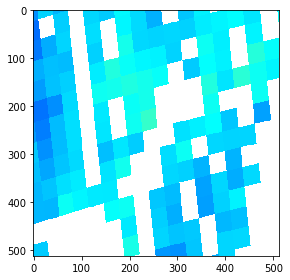

In [40]:

#東京港
bbox=[
    140.5755615, 
    35.1693180,
    139.0759277,
    35.7821707,
   
]



#左回りもしくは右回り時の対応
for i in range(len(bbox)):
    if bbox[i] >= 0:
        bbox[i] = bbox[i]%360
    else:
        bbox[i] = -(abs(bbox[i])%360) + 360


# 適当な日付を設定
day = "2019-12-31"

#s2_true_img = get_s2_true_img(bbox,day)
#io.imsave('s2_true_img.png', s2_true_img)
#s2_true_img = add_copyright(s2_true_img)
co_img =get_img(bbox,day,"CO")
io.imsave('co_img.png', co_img)
io.imshow(co_img)
#io.imshow(s2_true_img)
#io.imsave('s2_true_img.png', s2_true_img)

In [ ]:
fig,axs=plt.subplots(1,3,figsize=(8,16))
for ax, img in zip(axs,[s2_true_img,no2_img ,co_img ]):
    io.imshow(img,ax=ax)

一酸化炭素と二酸化窒素のカラースケール

In [47]:
# 画像をリサイズして連結する関数を用意
def get_concat_h(im1, im2):
    return cv2.hconcat([im1, im2])

# co_color_resize.pngはSentinel hubから切り出した一酸化炭素のカラースケール画像
#co_color = io.imread(f'img_other/co_color_resize.png')
co_color = cv2.cvtColor(co_img, cv2.COLOR_RGB2RGBA)
print(co_img.shape)
print(co_color.shape)

plt.imshow(get_concat_h(co_img, co_color))
#余分のデータをダウンロードする方法がない

NameError: name 'co_img' is not defined

日の変化

In [ ]:
imgs = []
days=6
fig,axsg=plt.subplots(days,3,figsize=(10,20))
for day,axs in zip(range(1, days),axsg):
    #print(f"2019-08-0{day}")
    true_img = get_s2_true_img(bbox,f"2019-08-0{day}")
    co_img = get_co_img(bbox, f"2019-08-0{day}")
    no2_img= get_no2_img(bbox, f"2019-08-0{day}")
    imgs=[true_img,co_img,no2_img]
    for i,ax, img in zip([0,1,2],axs,imgs):
        io.imshow(img,ax=ax)
        if i==1:
            ax.set_title(f"2019-08-{str(day).zfill(2)}")


<h1>年間の観測データを取得する関数を作成する


In [27]:
import logging
import threading
import time
def get_month_worker(get_img,year,month,days):
    logging.info("Thread %s: starting", f"{year}-{str(month).zfill(2)}")
    daily_imgs = []
    for day in days:
        date = f"{year}-{str(month).zfill(2)}-{str(day).zfill(2)}"
        path = 'daily_img/' + get_img.__name__ + '_' + date + '.png'
        if os.path.exists(path):
            continue
        daily_img = get_img(bbox, date)
        io.imsave(path, daily_img)
    logging.info("Thread %s: Ended", f"{year}-{str(month).zfill(2)}")

def get_daily_imgs(get_img, year): #画像の関数　と年
    months = range(1, 13) # １〜１２月
    days = range(1, 29)   # １〜28日（2月を考慮して28日までを扱う）
    for month in months:
        threading.Thread(name=month,target=get_month_worker,args=(get_img,year,month,days,)).start()
        

In [34]:
year="2020"	
get_daily_imgs(get_co_img, year)
get_daily_imgs(get_no2_img, year)

C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_co_img_2020-06-01.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_no2_img_2020-04-01.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_co_img_2020-07-01.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_no2_img_2020-06-01.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_no2_img_2020-07-01.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_co_img_2020-03-02.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launc

C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_co_img_2020-12-09.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_no2_img_2020-10-10.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_co_img_2020-08-10.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_no2_img_2020-05-06.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_no2_img_2020-09-10.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_co_img_2020-09-12.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launc

C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_co_img_2020-09-22.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_no2_img_2020-07-22.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_no2_img_2020-02-20.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_no2_img_2020-05-16.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_no2_img_2020-09-20.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: daily_img/get_no2_img_2020-07-23.png is a low contrast image
  del sys.path[0]
C:\Users\dev\Anaconda\lib\site-packages\ipykernel_lau

In [30]:
def get_mean_img(imgs):
    imgs = np.array(imgs)
    if len(imgs) != 0:
        img0 = imgs[0] #画像読み込み サイズチェック
        rows, cols, channels = img0.shape
        img_ave = np.zeros((rows, cols, channels)) #平均値入れる箱を初期化

        for img_tmp in imgs:
            if img_tmp.shape != img0.shape:
                print(i + ' : 画像ファイルサイズが異なります。\n全て同じサイズにしてください。\n')
            else:
                img_ave = img_ave + img_tmp

        img_ave = img_ave / len(imgs)
        
        return img_ave.astype(np.uint8)



def get_titled_imgs(get_img, year):

    imgs = []
    
    for month in months:
        daily_imgs = []

        for day in days:
            date = f"{year}-{str(month).zfill(2)}-{str(day).zfill(2)}"

            path = f'daily_img/{get_img.__name__}_{date}.png'
            daily_img = io.imread(path)
            daily_imgs.append(daily_img)

        img = get_mean_img(daily_imgs)

        cv2.putText(img, f"{year}-{month}", (10, 30),
                   cv2.FONT_HERSHEY_PLAIN, 2.5,
                   (255, 255, 255), 1, cv2.LINE_AA)
        img = add_copyright(img)

        imgs.append(img)
        io.imsave(f'img/{get_img.__name__}_{date[:7]}.png', img)

    return imgs

In [29]:
def show_imgs(imgs, suptitle=None):
    row = 3
    col = 4

    plt.figure(figsize=(10, 10))
    if suptitle is not None:
        plt.suptitle(suptitle)
    for i in range(len(imgs)):

        plt.subplot(row, col, i + 1)
        plt.title(f"{str(i + 1).zfill(2)}")
        plt.imshow(imgs[i])


def make_gif(imgs, filename='default', color=None):
    ims = []
    fig = plt.figure()

    for img in imgs:
        if color is not None:
            ims.append([plt.imshow(get_concat_h(img, color))])
        else:
            ims.append([plt.imshow(img)])

    ani = animation.ArtistAnimation(fig, ims, interval=700)
    ani.save(f'img/{filename}.gif', writer='pillow')
    plt.close()

 一酸化炭素の年間の濃度変化を可視化する

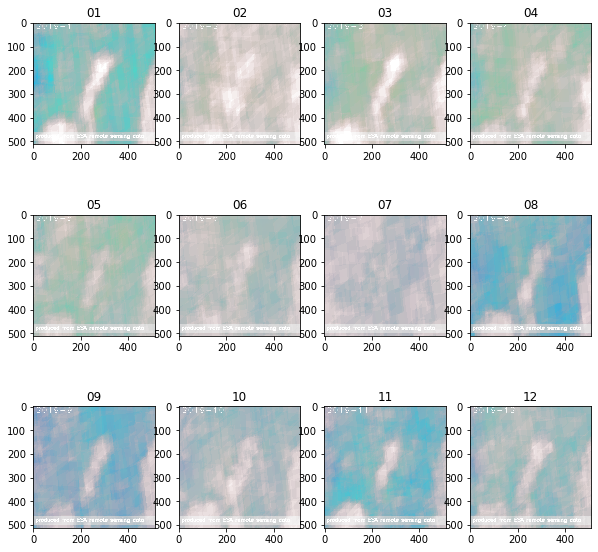

In [32]:
year="2019"
co_imgs = get_titled_imgs(get_co_img, year)
show_imgs(co_imgs)
make_gif(co_imgs, filename=f"co_{year}")
#HTML('f="img/co_{year}.gif">')

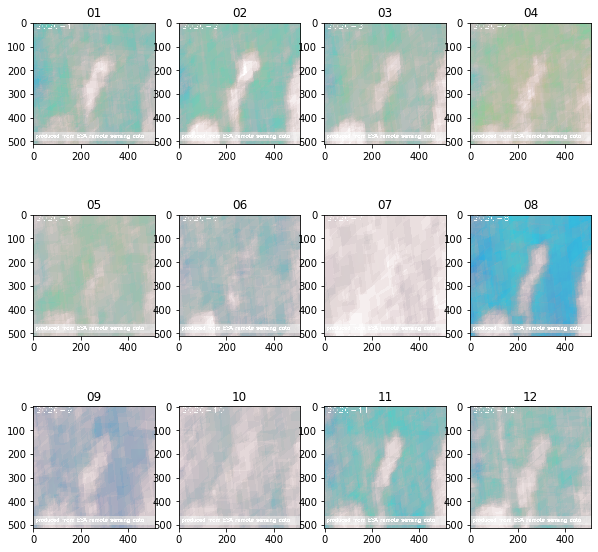

In [35]:
year="2020"
co_imgs = get_titled_imgs(get_co_img, year)
show_imgs(co_imgs)
make_gif(co_imgs, filename=f"co_{year}")
#HTML('f="img/co_{year}.gif">')

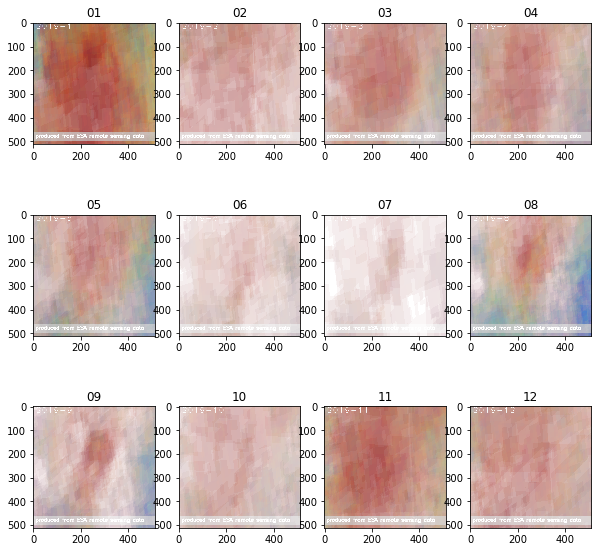

In [33]:
year="2019"
no2_imgs = get_titled_imgs(get_no2_img, year)
show_imgs(no2_imgs)
make_gif(no2_imgs, filename=f"no2_{year}")

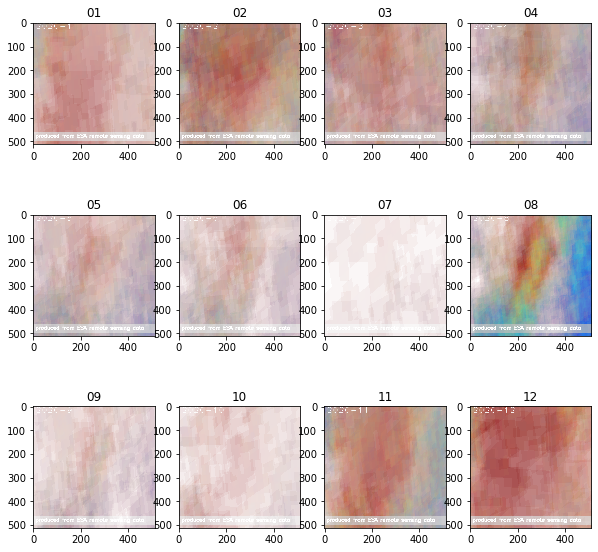

In [36]:
year="2020"
no2_imgs = get_titled_imgs(get_no2_img, year)
show_imgs(no2_imgs)
make_gif(no2_imgs, filename=f"no2_{year}")

<h1>2019年と2020年の各月ごとの平均値の画像

In [37]:
#画像 Concat 
def get_concat_h(im1, im2): #
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def get_concat_imgs(type):
    months = range(1, 13) # １〜１２月
    imgs = []
    for month in months:
        month = str(month)

        img_1 = io.imread(f'img/get_{type}_img_2019-{month.zfill(2)}.png')
        img_2 = io.imread(f'img/get_{type}_img_2020-{month.zfill(2)}.png')
        concat_img = cv2.hconcat([img_1, img_2])
        io.imsave(f'img/{type}_{month.zfill(2)}_concat.png', concat_img)
        imgs.append(concat_img)
    return imgs

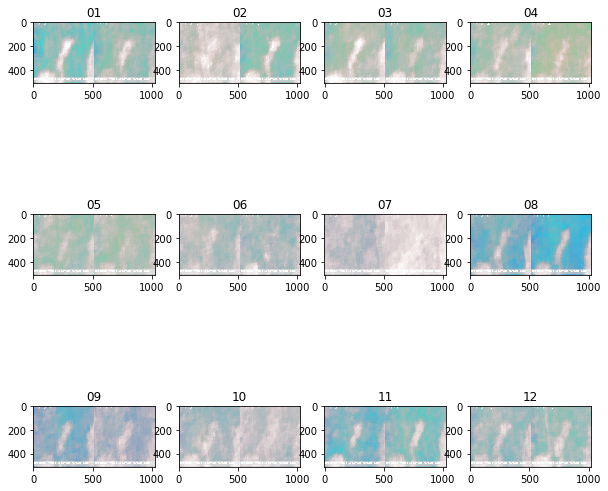

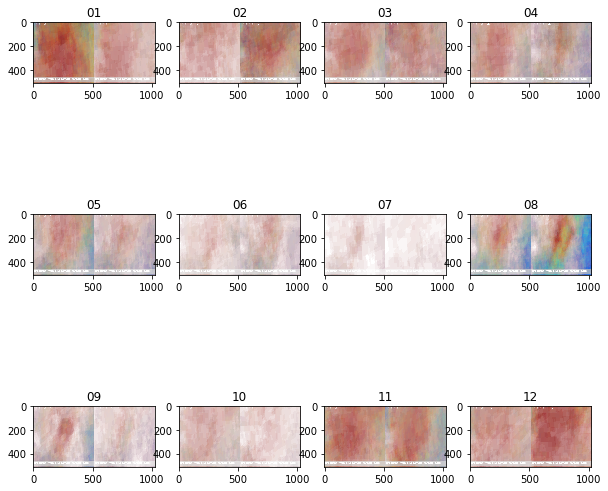

In [42]:
co_concat_imgs = get_concat_imgs(type="co")
show_imgs(co_concat_imgs)
make_gif(co_concat_imgs, filename=f"co_concat")

no2_concat_imgs = get_concat_imgs(type="no2")
show_imgs(no2_concat_imgs)
make_gif(no2_concat_imgs, filename=f"no2_concat")


In [43]:
HTML('<img src="img/no2_concat.gif">')


In [44]:
HTML('<img src="img/co_concat.gif">')